In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
import getpass
import matplotlib.ticker as ticker
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns

file_path = r'C:\Users\leube\Ironhack\Bootcamp\week_4\bike+sharing+dataset\day.csv'

df = pd.read_csv(file_path)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


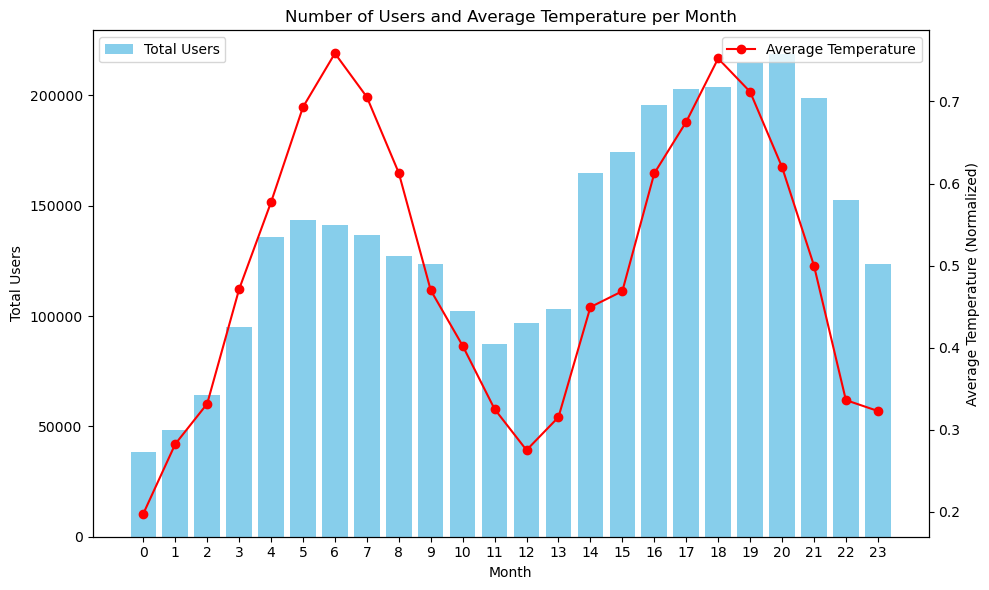

In [35]:
df['dteday'] = pd.to_datetime(df['dteday'])

df['total_users'] = df['casual'] + df['registered']
users_per_month = df.groupby(df['dteday'].dt.to_period('M'))['total_users'].sum()

avg_temp_per_month = df.groupby(df['dteday'].dt.to_period('M'))['temp'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(users_per_month.index.astype(str), users_per_month.values, color='skyblue', label='Total Users')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Users')
ax1.set_title('Number of Users and Average Temperature per Month')

ax2 = ax1.twinx()
ax2.plot(avg_temp_per_month.index.astype(str), avg_temp_per_month.values, color='red', marker='o', linestyle='-', label='Average Temperature')
ax2.set_ylabel('Average Temperature (Normalized)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(range(0, len(users_per_month)), range(0, len(users_per_month)))
plt.tight_layout()

plt.show()

In [36]:
!pip install sqlalchemy

In [37]:
!pip install pymysql

In [ ]:
password = getpass.getpass(prompt="Enter your MySQL password: ")

try:
    connection = pymysql.connect(
        host='127.0.0.1',
        user='root',
        password=password,
        database='biking'
    )
    print("Direct connection for data retrieval successful!")

    query_weather_type = """
    SELECT 
        wt.category AS weather_type,
        SUM(bsd.registered) AS total_registered,  
        SUM(bsd.casual) AS total_casual  
    FROM 
        biking.bike_sharing_data AS bsd  
    JOIN 
        biking.weather_type AS wt ON bsd.weathersit = wt.weather_type_id  
    GROUP BY 
        wt.category;
    """
    df_weather_type = pd.read_sql(query_weather_type, connection)

    query_weekday_weekend = """
    SELECT 
        'Weekday' AS day_type, 
        SUM(bsd.registered) AS total_registered,  
        SUM(bsd.casual) AS total_casual  
    FROM 
        biking.bike_sharing_data AS bsd  
    WHERE 
        bsd.weekday NOT IN (0, 6);
    """
    df_weekday_weekend = pd.read_sql(query_weekday_weekend, connection)

    query_rain = """
    SELECT 
        SUM(bsd.registered) AS total_registered,  
        SUM(bsd.casual) AS total_casual  
    FROM 
        biking.bike_sharing_data AS bsd  
    JOIN 
        biking.weather_type AS wt ON bsd.weathersit = wt.weather_type_id  
    WHERE 
        bsd.weathersit IN (3, 4);
    """
    df_rain = pd.read_sql(query_rain, connection)

    connection.close()

    print("Weather Type Data:")
    print(df_weather_type.head())

    print("Weekday/Weekend Data:")
    print(df_weekday_weekend.head())

    print("Rain Data:")
    print(df_rain.head())

except pymysql.MySQLError as e:
    print(f"An error occurred while querying: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
bar_width = 0.4
r1 = np.arange(len(df_weather_type))
r2 = [x + bar_width for x in r1]

sky_blue = '#87CEEB'
sunshine_yellow = '#FFD700'

plt.figure(figsize=(6, 4))

plt.barh(r1, df_weather_type_melted[df_weather_type_melted['user_type'] == 'total_registered']['total_users'],
         color=sky_blue, height=bar_width, label='Registered Users')

plt.barh(r2, df_weather_type_melted[df_weather_type_melted['user_type'] == 'total_casual']['total_users'],
         color=sunshine_yellow, height=bar_width, label='Casual Users', alpha=0.9)

plt.ylabel('Weather Type', fontweight='bold')
plt.xlabel('Number of Users', fontweight='bold')
plt.yticks([r + bar_width/2 for r in r1], df_weather_type['weather_type'])
plt.title('Number of Registered and Casual Users by Weather Type')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(title='User Type')
plt.tight_layout()
plt.show()


In [ ]:
data = {
    'day_type': ['Weekday'],
    'total_registered': [2045201],
    'total_casual': [325644]
}
df_weekday_weekend = pd.DataFrame(data)

df_weekday_weekend_melted = pd.melt(df_weekday_weekend, id_vars='day_type', 
                                    value_vars=['total_registered', 'total_casual'],
                                    var_name='user_type', value_name='total_users')

plt.figure(figsize=(6, 4))

bar_width = 0.4
x = df_weekday_weekend_melted['day_type'].unique()
x_pos = [0]

for idx, user_type in enumerate(df_weekday_weekend_melted['user_type'].unique()):
    plt.bar(x_pos[0] - bar_width/2 + idx*bar_width, 
            df_weekday_weekend_melted[df_weekday_weekend_melted['user_type'] == user_type]['total_users'], 
            width=bar_width, 
            label=user_type, 
            color='#B0E0E6' if user_type == 'total_registered' else '#FFD700')

plt.title('Number of Registered and Casual Users on Weekdays')
plt.xlabel('Day Type')
plt.ylabel('Number of Users')
plt.xticks(x_pos, ['Weekday'])
plt.legend(title='User Type')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

plt.show()

In [ ]:
data = {
    'total_registered': [33974],
    'total_casual': [3895]
}
df_rain = pd.DataFrame(data)

df_rain_melted = pd.melt(df_rain, value_vars=["total_registered", "total_casual"], 
                         var_name="user_type", value_name="total_users")

plt.figure(figsize=(6, 4))

sns.barplot(data=df_rain_melted, x="user_type", y="total_users", 
            palette={"total_registered": "#B0E0E6", "total_casual": "#FFD700"})

plt.title('Number of Registered and Casual Users When It Rains')
plt.xlabel('User Type')
plt.ylabel('Number of Users')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

plt.show()

In [ ]:
sky_blue = '#87CEEB'
sunshine_yellow = '#FFD700'

plt.figure(figsize=(10, 6))
ax = df.set_index('Date').plot(kind='bar', rot=0, color=[sky_blue,sunshine_yellow,'#99ff99'])

plt.title('Average Temperature, Humidity, and Windspeed by Date', fontsize=16)
plt.xlabel('Date', fontsize=14) 
plt.ylabel('Values', fontsize=14) 
plt.tight_layout() 
plt.show()

plt.savefig('best_worse_month_temp', format='jpeg', dpi=300)

In [ ]:
username = 'root'
password = 'Ironhack2024'
host = 'localhost'
database = 'biking'

connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database}'

engine = create_engine(connection_string)

query = """
SELECT 
    CASE 
        WHEN mnth = 1 THEN 'January'
        WHEN mnth = 2 THEN 'February'
        WHEN mnth = 3 THEN 'March'
        WHEN mnth = 4 THEN 'April'
        WHEN mnth = 5 THEN 'May'
        WHEN mnth = 6 THEN 'June'
        WHEN mnth = 7 THEN 'July'
        WHEN mnth = 8 THEN 'August'
        WHEN mnth = 9 THEN 'September'
        WHEN mnth = 10 THEN 'October'
        WHEN mnth = 11 THEN 'November'
        WHEN mnth = 12 THEN 'December'
    END AS month,
    SUM(casual + registered) AS total_users
FROM 
    bike_sharing_data
GROUP BY 
    mnth
ORDER BY 
    mnth;
"""

df = pd.read_sql(query, engine)

df.head()

plt.figure(figsize=(12, 8))

sns.barplot(x="month", y="total_users", data=df)

plt.title("Total Users by Month")
plt.xlabel("Month")
plt.ylabel("Total Users")

plt.xticks(rotation=0)

plt.show()

In [ ]:
username = 'root'
password = 'Ironhack2024'
host = 'localhost'
database = 'biking'

connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database}'

engine = create_engine(connection_string)

query = """
SELECT 
    CASE 
        WHEN mnth = 1 THEN 'January'
        WHEN mnth = 2 THEN 'February'
        WHEN mnth = 3 THEN 'March'
        WHEN mnth = 4 THEN 'April'
        WHEN mnth = 5 THEN 'May'
        WHEN mnth = 6 THEN 'June'
        WHEN mnth = 7 THEN 'July'
        WHEN mnth = 8 THEN 'August'
        WHEN mnth = 9 THEN 'September'
        WHEN mnth = 10 THEN 'October'
        WHEN mnth = 11 THEN 'November'
        WHEN mnth = 12 THEN 'December'
    END AS month,
    SUM(casual + registered) AS total_users
FROM 
    bike_sharing_data
GROUP BY 
    mnth
ORDER BY 
    mnth;
"""

df = pd.read_sql(query, engine)

df.head()

plt.figure(figsize=(12, 8))

sns.lineplot(x="month", y="total_users", data=df, marker='o', sort=False)

plt.title("Total Users by Month")
plt.xlabel("Month")
plt.ylabel("Total Users")

plt.xticks(rotation=45)

plt.show()

In [ ]:
username = 'root'
password = 'Ironhack2024'
host = 'localhost'
database = 'biking'

connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database}'

engine = create_engine(connection_string)

query = """
SELECT 
    s.name AS season_name,
    SUM(bsd.casual) AS total_casual_users,
    SUM(bsd.registered) AS total_registered_users,
    SUM(bsd.casual + bsd.registered) AS total_users
FROM 
    bike_sharing_data bsd
JOIN 
    season s ON bsd.season = s.season_id
GROUP BY 
    s.name;
"""

df = pd.read_sql(query, engine)

df.head()

sky_blue = '#87CEEB'
sunshine_yellow = '#FFD700'

plt.figure(figsize=(12, 8))

sns.barplot(x="season_name", y="total_users", data=df,color=sky_blue)

plt.title("Total Users by Season")
plt.xlabel("Season")
plt.ylabel("Total Users")

plt.xticks(rotation=0)

plt.show()

In [ ]:
username = 'root'
password = 'Ironhack2024'
host = 'localhost'
database = 'biking'

connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database}'

engine = create_engine(connection_string)

query = """
SELECT 
    CASE
        WHEN s.name IN ('spring', 'summer') THEN 'spring + summer'
        WHEN s.name IN ('fall', 'winter') THEN 'fall + winter'
    END AS season_group,
    SUM(bsd.casual) AS total_casual_users,
    SUM(bsd.registered) AS total_registered_users,
    SUM(bsd.casual + bsd.registered) AS total_users
FROM 
    bike_sharing_data bsd
JOIN 
    season s ON bsd.season = s.season_id
GROUP BY 
    season_group;
"""

df = pd.read_sql(query, engine)

df.head()

sky_blue = '#87CEEB'
sunshine_yellow = '#FFD700'

plt.figure(figsize=(6, 6))

sns.barplot(x="season_group", y="total_users", data=df,color=sky_blue, width = 0.5)

plt.title("Total Users by Season")
plt.xlabel("Season")
plt.ylabel("Total Users")

plt.xticks(rotation=0)

plt.show()